<a href="https://colab.research.google.com/github/JoDeMiro/ImageProcessing/blob/main/08_Image_FFT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08 - Image - Fun wiht Fourier Transform

Csak egy kis móka.

MLPRegression soronként oszloponkétn n neuronnal.

Az elöző részben:

Azt láttuk, hogy nagyon lassan tanulja ráadásul rosszul becsüli a képből vett sorokat, pedig ez egy könnyű feladat lenne.

Ezért két másik módszert vizsgálunk meg.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%capture
!rm *.png
!wget https://github.com/JoDeMiro/Data/raw/main/Images/woman1.png
!wget https://github.com/JoDeMiro/Data/raw/main/Images/woman2.png

In [ ]:
import skimage.io
import skimage.transform

In [ ]:
pic1 = skimage.io.imread('https://github.com/JoDeMiro/Data/raw/main/Images/woman1.png')

print(type(pic1))

print(pic1.shape)

red1   = pic1[:, :, 0]
green1 = pic1[:, :, 1]
blue1  = pic1[:, :, 2]

<class 'numpy.ndarray'>
(400, 610, 3)


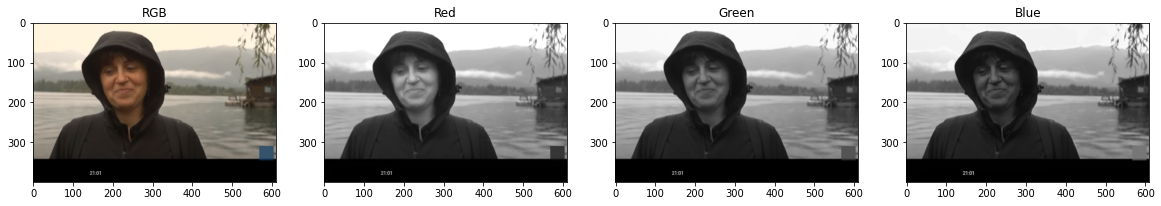

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))

ax1.imshow(pic1, cmap='gray'); ax1.set_title('RGB')
ax2.imshow(red1, cmap='gray'); ax2.set_title('Red')
ax3.imshow(green1, cmap='gray'); ax3.set_title('Green')
ax4.imshow(blue1, cmap='gray'); ax4.set_title('Blue')

plt.show()

In [ ]:
def get_picture(file = 'https://github.com/JoDeMiro/Data/raw/main/Images/woman2.png'):
  pic = skimage.io.imread(file)

  print(type(pic))
  print(pic.shape)

  red   = pic[:, :, 0]
  green = pic[:, :, 1]
  blue  = pic[:, :, 2]

  return pic, red, green, blue


def show_irgb(pic):
  red   = pic[:, :, 0]
  green = pic[:, :, 1]
  blue  = pic[:, :, 2]

  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))

  ax1.imshow(pic, cmap='gray'); ax1.set_title('RGB')
  ax2.imshow(red, cmap='gray'); ax2.set_title('Red')
  ax3.imshow(green, cmap='gray'); ax3.set_title('Green')
  ax4.imshow(blue, cmap='gray'); ax4.set_title('Blue')

  plt.show()

def show_gray(pic, w=5, h=8):
  fig, (ax1) = plt.subplots(1, 1, figsize=(w, h))

  ax1.imshow(pic, cmap='gray'); ax1.set_title('Gray')

  plt.show()


def crop_img(pic, x, y, w, h):
  red_   = pic[y:y+h, x:x+w, 0]
  green_ = pic[y:y+h, x:x+w, 1]
  blue_  = pic[y:y+h, x:x+w, 2]
  pic_   = pic[y:y+h, x:x+w, :]

  return pic_, red_, green_, blue_

def resize_img(pic, w, h):
  pic_ = skimage.transform.resize(pic, (w, h))

  red_   = pic_[:, :, 0]
  green_ = pic_[:, :, 1]
  blue_  = pic_[:, :, 2]

  return pic_, red_, green_, blue_

def to_gray_img(pic):
  grey_ = (pic[:, :, 0] + pic[:, :, 1] + pic[:, :, 2])/3

  return grey_


<class 'numpy.ndarray'>
(400, 610, 3)
float64
0.9607843137254902


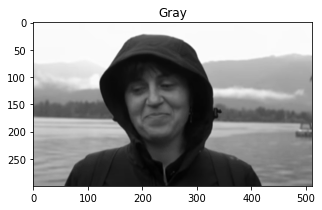

In [ ]:
img, _, _, _ = get_picture('https://github.com/JoDeMiro/Data/raw/main/Images/woman1.png')

croped_img, _, _, _ = crop_img(img, 0, 0, 512, 300)

resized_img, _, _, _, = resize_img(croped_img, 300, 512)

gray_img = to_gray_img(resized_img)

woman1 = gray_img

print(woman1.dtype)
print(woman1.max())

show_gray(woman1)

# Meg van a képem, jöhet a hülyeség.

Menjünk végig a kép sorain, és mindegyiken csináljuk mega a Fourier Transformációt, vegyük a domináns frekvenciákat a többit tobjuk el és a domináns frekvenciák alapján rekonstruáljuk a képet.

In [ ]:
# A kép
# woman1      <- 0-255
# woman2      <- 0-1

img = woman1.copy()

print(img.shape)

rows = img.shape[0]
cols = img.shape[1]

_X_indicator = np.arange(0, 1, 1/cols)
print(_X_indicator.shape)

_X_indicator = _X_indicator.reshape(-1, 1)
print(_X_indicator.shape)


(300, 512)
(512,)
(512, 1)


# Discrete Fast Fourier Transformation

Most jön a lényeg,

Vegyük azt a sort és csináljuk meg rajta DFT Transzformációt,

Elemezzük a komponenseket,

Majd azoknak a komponenseknek a segítségével, amelyek egy bizonyos szint felett vannak rekonstruáljuk az adatokat.

Néhány hivatkozás a saját repomból:

https://github.com/JoDeMiro/ImageProcessing

https://github.com/JoDeMiro/ImageProcessing/blob/main/43_Image_FFT_Zajsz%C5%B1r%C3%A9se.ipynb

https://github.com/JoDeMiro/ImageProcessing/blob/main/42_Image_Discrete_Wavelet_Ttransform_1.ipynb

https://github.com/JoDeMiro/ImageProcessing/blob/main/41_Image_Fun_with_FFT_1.ipynb

https://github.com/JoDeMiro/ImageProcessing/blob/main/40_Image_Compression_with_FFT.ipynb

https://github.com/JoDeMiro/ImageProcessing/blob/main/20_Image_FFT_Alapok_1.ipynb



## Tartalom

Zajszűrés Fast Fourier Transzformáció segítségével 1 Dimenziós adatokon.

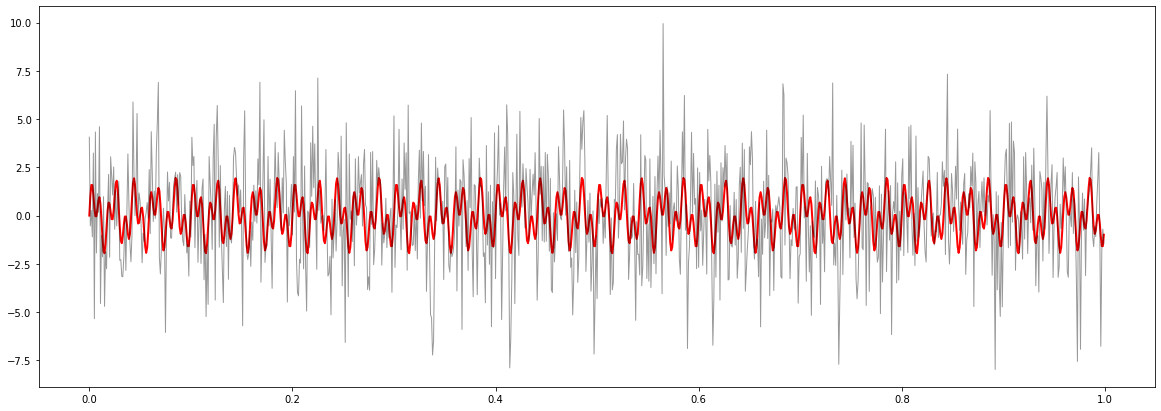

In [ ]:
def generate(u, v):
  step = 0.001

  np.random.seed(1)

  time = np.arange(0,1,step)
  wave = np.sin(2*np.pi*u*time) + np.sin(2*np.pi*v*time)
  noisy_wave = wave + 2.5*np.random.randn(len(time))

  return time, wave, noisy_wave

time, wave, noisy_wave = generate(50, 120)

plt.figure(figsize=(20, 7))
plt.plot(time, wave, color='red', lw=2)
plt.plot(time, noisy_wave, color='black', lw=1, alpha=0.4)
plt.show()

## Compute the Fast Fourier Transform (FFT)

In [ ]:
def fft(noisy_wave):
  n = len(time)
  y = np.fft.fft(noisy_wave, n)                 # Compute the FFT
  PSD = y * np.conj(y) / n                      # Power spectrum (power per freq)
  freq = (1/(step*n)) * np.arange(n)            # Create x-axis of frequencies in Hz
  L = np.arange(1, np.floor(n/2) ,dtype='int')  # Only plot the first half of freqs

  return PSD, y, freq, L

PSD, y, freq, L = fft(noisy_wave)


## Use the PSD to filter out noise

In [ ]:
def filter(PSD, y, cut=100):
  index = PSD > cut               # Find all freqs with large power
  PSDclean = PSD * index          # Zero out all others
  masked = index * y              # Zero out small Fourier coeffs. in Y
  filtered = np.fft.ifft(masked)  # Inverse FFT for filtered time signal

  return PSDclean, filtered, cut

PSDclean, filtered, cut = filter(PSD, y)

In [ ]:
type(PSD)

numpy.ndarray

In [ ]:
PSD.shape

(1000,)

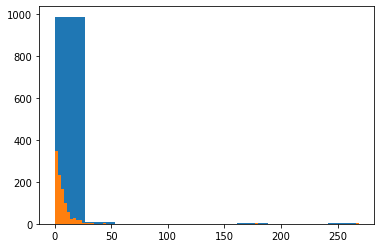

In [ ]:
plt.hist(PSD)
plt.hist(PSD, bins=100)
plt.show()

## Plots

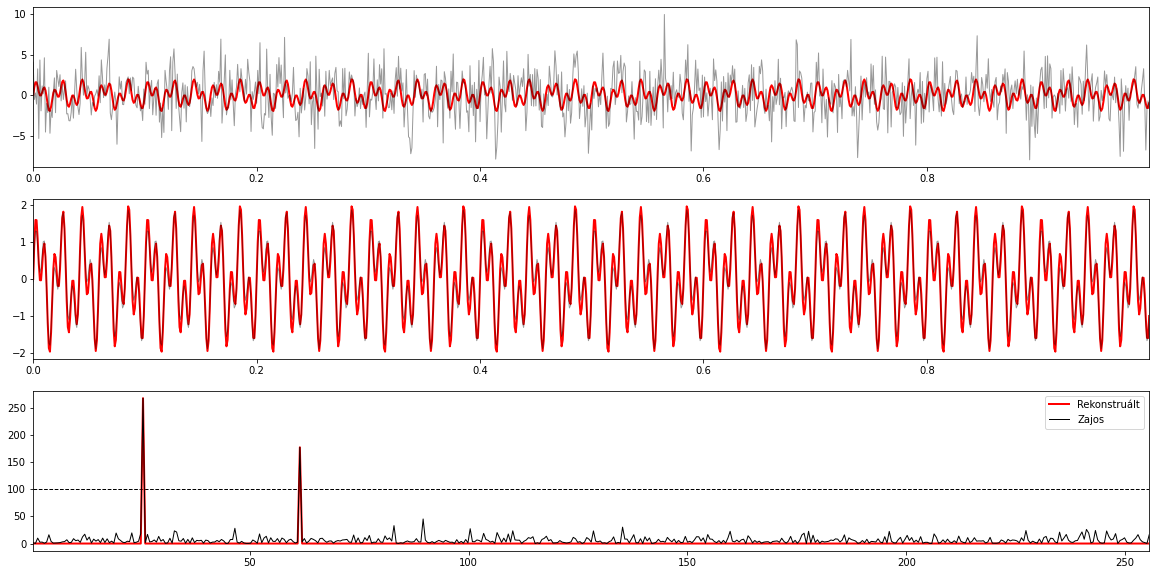

In [ ]:
def show(time, wave, noisy_wave, PSD, y, freq, L, PSDclean, filtered, cut):
  fig,axs = plt.subplots(3,1, figsize=(20, 10))

  plt.sca(axs[0])
  plt.plot(time, wave, color='red', lw=2)
  plt.plot(time, noisy_wave, color='black', lw=1, alpha=0.4)
  plt.xlim(time[0],time[-1])

  plt.sca(axs[1])
  plt.plot(time, wave, color='red', lw=2)
  plt.plot(time, filtered, color='black', lw=1, alpha=0.4)
  plt.xlim(time[0],time[-1])

  plt.sca(axs[2])
  plt.plot(freq[L],PSDclean[L], color='red', lw=2, label='Rekonstruált')
  plt.plot(freq[L],PSD[L], color='black', lw=1, alpha=1, label='Zajos')
  plt.hlines(cut, freq[L[0]], freq[L[-1]], lw=1, linestyles='--')
  plt.xlim(freq[L[0]],freq[L[-1]])
  plt.legend()

  plt.show()

show(time, wave, noisy_wave, PSD, y, freq, L, PSDclean, filtered, cut)

## Ugyan ez interaktívan

In [ ]:
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

from ipywidgets import interact
from ipywidgets import IntSlider, FloatSlider

def fuck(u, v, cut):
  time, wave, noisy_wave = generate(u, v)
  PSD, y, freq, L = fft(noisy_wave)
  PSDclean, filtered, cut = filter(PSD, y, cut)
  show(time, wave, noisy_wave, PSD, y, freq, L, PSDclean, filtered, cut)

u = IntSlider(min=10, max=200, step=1, value=10)
v = IntSlider(min=10, max=300, step=1, value=270)
c = IntSlider(min=0, max=100, step=1, value=100)

interact(fuck, u=u, v=v, cut=c);

interactive(children=(IntSlider(value=10, description='u', max=200, min=10), IntSlider(value=270, description=…

##  Most ezt a kép soron

In [ ]:
sor = 200

In [ ]:
img = woman1.copy()

In [ ]:
_y = img[sor, :]

In [ ]:
_y.shape

(512,)

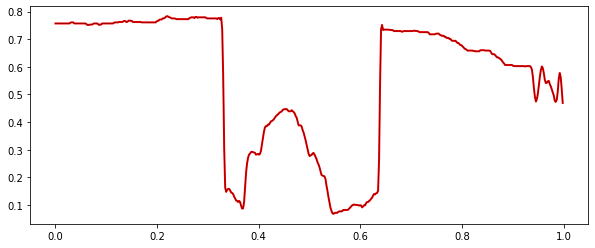

In [ ]:
step = 1/_y.size                  # <- ezt majd átrini

time = np.arange(0, 1, step)      # <- ezt majd átrini
wave = _y.copy()
noisy_wave = _y.copy()

plt.figure(figsize=(10, 4))
plt.plot(time, wave, color='red', lw=2)
plt.plot(time, noisy_wave, color='black', lw=1, alpha=0.4)
plt.show()

In [ ]:
n = len(time)
y = np.fft.fft(noisy_wave, n)                # Compute the FFT
PSD = y * np.conj(y) / n                     # Power spectrum (power per freq)
freq = (1/(step*n)) * np.arange(n)           # Create x-axis of frequencies in Hz
L = np.arange(1, np.floor(n/2), dtype='int') # Only plot the first half of freqs

In [ ]:
type(PSD)

numpy.ndarray

In [ ]:
PSD.shape

(512,)

In [ ]:
index = PSD > 2           # Find all freqs with large power

type(index)

np.count_nonzero(index)

5

In [ ]:
index = PSD > 1           # Find all freqs with large power

type(index)

np.count_nonzero(index)

9

In [ ]:
index = PSD > 0.3           # Find all freqs with large power

type(index)

np.count_nonzero(index)

13

In [ ]:
PSDclean = PSD * index          # Zero out all others
masked = index * y              # Zero out small Fourier coeffs. in Y
filtered = np.fft.ifft(masked)  # Inverse FFT for filtered time signal

In [ ]:
type(filtered)

numpy.ndarray

In [ ]:
filtered.dtype

dtype('complex128')

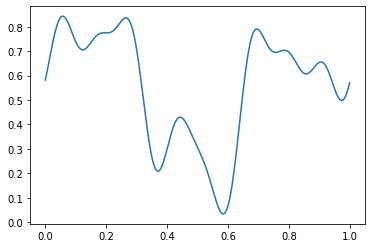

In [ ]:
plt.plot(time, filtered)
plt.show()

In [ ]:
filtered_float64 = filtered.astype('float64')

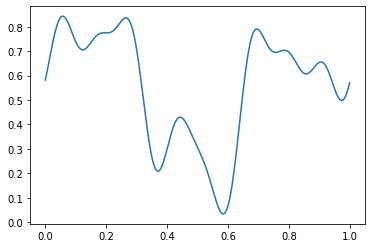

In [ ]:
plt.plot(time, filtered_float64)
plt.show()

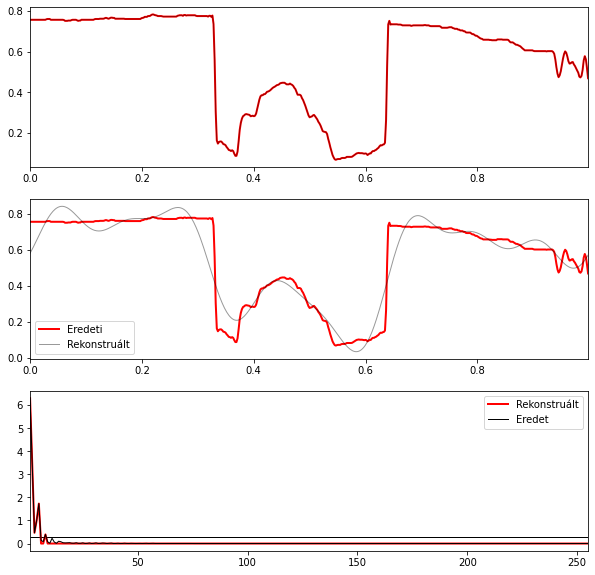

In [ ]:
fig,axs = plt.subplots(3,1, figsize=(10, 10))

plt.sca(axs[0])
plt.plot(time, wave, color='red', lw=2)
plt.plot(time, noisy_wave, color='black', lw=1, alpha=0.4)
plt.xlim(time[0],time[-1])

plt.sca(axs[1])
plt.plot(time, wave, color='red', lw=2, label='Eredeti')
plt.plot(time, filtered, color='black', lw=1, alpha=0.4, label='Rekonstruált')
plt.xlim(time[0],time[-1])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L],PSDclean[L], color='red', lw=2, label='Rekonstruált')
plt.plot(freq[L],PSD[L], color='black', lw=1, alpha=1, label='Eredet')
plt.hlines(0.3, freq[L[0]], freq[L[-1]], lw=1)
plt.xlim(freq[L[0]],freq[L[-1]])
plt.legend()

plt.show()

In [ ]:
threshold = 0.3                   # <-- ez alapján lehet meghatározni, hogy milyen nagy amplitudojú frekvenciákat vegyen csak figyelembe

collector = []

step = 1/cols                     # <- ezt majd átrini

time = np.arange(0, 1, step)      # <- ezt majd átrini
n = len(time)

for sor in range(0, rows):
  _y = img[sor, :]

  wave = _y.copy()                # <-- kell a .copy()?
  noisy_wave = _y.copy()

#  plt.figure(figsize=(10, 4))
#  plt.plot(time, wave, color='red', lw=2)
#  plt.show()

  y = np.fft.fft(noisy_wave,n)                 # Compute the FFT
  PSD = y * np.conj(y) / n                     # Power spectrum (power per freq)
  freq = (1/(step*n)) * np.arange(n)           # Create x-axis of frequencies in Hz
  L = np.arange(1, np.floor(n/2), dtype='int') # Only plot the first half of freqs


  index = PSD > threshold           # 0.3, 1.0, 2.0

  count = np.count_nonzero(index)
  # print('row {}, count {}'.format(sor, count))

  PSDclean = PSD * index         # Zero out all others
  masked = index * y             # Zero out small Fourier coeffs. in Y
  filtered = np.fft.ifft(masked) # Inverse FFT for filtered time signal

  collector.append(filtered)

reconstructed_img = np.array(collector)
print(reconstructed_img.shape)

reconstructed_img_float64 = reconstructed_img.astype('float64')



(300, 512)


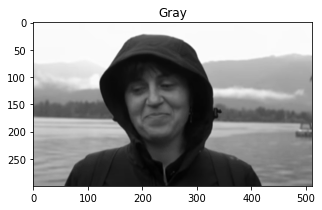

In [ ]:
show_gray(woman1)

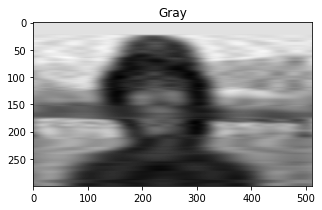

In [ ]:
show_gray(reconstructed_img_float64)

In [ ]:
threshold = 0.05                  # <-- ez alapján lehet meghatározni, hogy milyen nagy amplitudojú frekvenciákat vegyen csak figyelembe

collector = []

step = 1/cols                     # <- ezt majd átrini

time = np.arange(0, 1, step)      # <- ezt majd átrini
n = len(time)

for sor in range(0, rows):
  _y = img[sor, :]

  wave = _y.copy()                # <-- kell a .copy()?
  noisy_wave = _y.copy()

#  plt.figure(figsize=(10, 4))
#  plt.plot(time, wave, color='red', lw=2)
#  plt.show()

  y = np.fft.fft(noisy_wave,n)                 # Compute the FFT
  PSD = y * np.conj(y) / n                     # Power spectrum (power per freq)
  freq = (1/(step*n)) * np.arange(n)           # Create x-axis of frequencies in Hz
  L = np.arange(1, np.floor(n/2), dtype='int') # Only plot the first half of freqs


  index = PSD > threshold           # 0.3, 1.0, 2.0

  count = np.count_nonzero(index)
  # print('row {}, count {}'.format(sor, count))

  PSDclean = PSD * index         # Zero out all others
  masked = index * y             # Zero out small Fourier coeffs. in Y
  filtered = np.fft.ifft(masked) # Inverse FFT for filtered time signal

  collector.append(filtered)

reconstructed_img = np.array(collector)
print(reconstructed_img.shape)

reconstructed_img_float64 = reconstructed_img.astype('float64')



(300, 512)


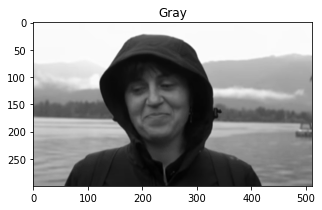

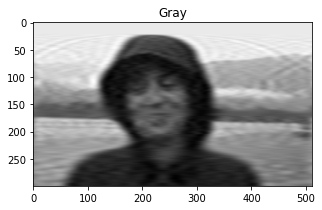

In [ ]:
show_gray(woman1)
show_gray(reconstructed_img_float64)

In [ ]:

def fft(_threshold, _gray_image):
  threshold = _threshold                # <-- ez alapján lehet meghatározni, hogy milyen nagy amplitudojú frekvenciákat vegyen csak figyelembe

  collector = []

  step = 1/cols                         # <- ezt majd átrini

  time = np.arange(0, 1, step)          # <- ezt majd átrini
  n = len(time)

  for sor in range(0, rows):
    _y = _gray_image[sor, :]

    y = np.fft.fft(_y, n)               # Compute the FFT
    PSD = y * np.conj(y) / n            # Power spectrum (power per freq)

    index = PSD > threshold           # 0.3, 1.0, 2.0

    count = np.count_nonzero(index)
    # print('row {}, count {}'.format(sor, count))

    PSDclean = PSD * index          # Zero out all others
    masked = index * y              # Zero out small Fourier coeffs. in Y
    filtered = np.fft.ifft(masked)  # Inverse FFT for filtered time signal

    collector.append(filtered)

  reconstructed_img = np.array(collector)

  reconstructed_img_float64 = reconstructed_img.astype('float64')

  return reconstructed_img_float64

In [ ]:
rec_image = fft(0.05, img)

In [ ]:
def show_rec(threshold):
  rec_image = fft(threshold, img)
  show_gray(rec_image, 8, 9)

In [ ]:
interact(show_rec, threshold=FloatSlider(min=0.1, max=2.4, step=0.1, value=0.1));

interactive(children=(FloatSlider(value=0.1, description='threshold', max=2.4, min=0.1), Output()), _dom_class…

In [ ]:
interact(show_rec, threshold=FloatSlider(min=0.01, max=0.4, step=0.01, value=0.1));

interactive(children=(FloatSlider(value=0.1, description='threshold', max=0.4, min=0.01, step=0.01), Output())…

In [ ]:
interact(show_rec, threshold=FloatSlider(min=0.001, max=0.1, step=0.001, value=0.002));

interactive(children=(FloatSlider(value=0.002, description='threshold', max=0.1, min=0.001, step=0.001), Outpu…

## Valami

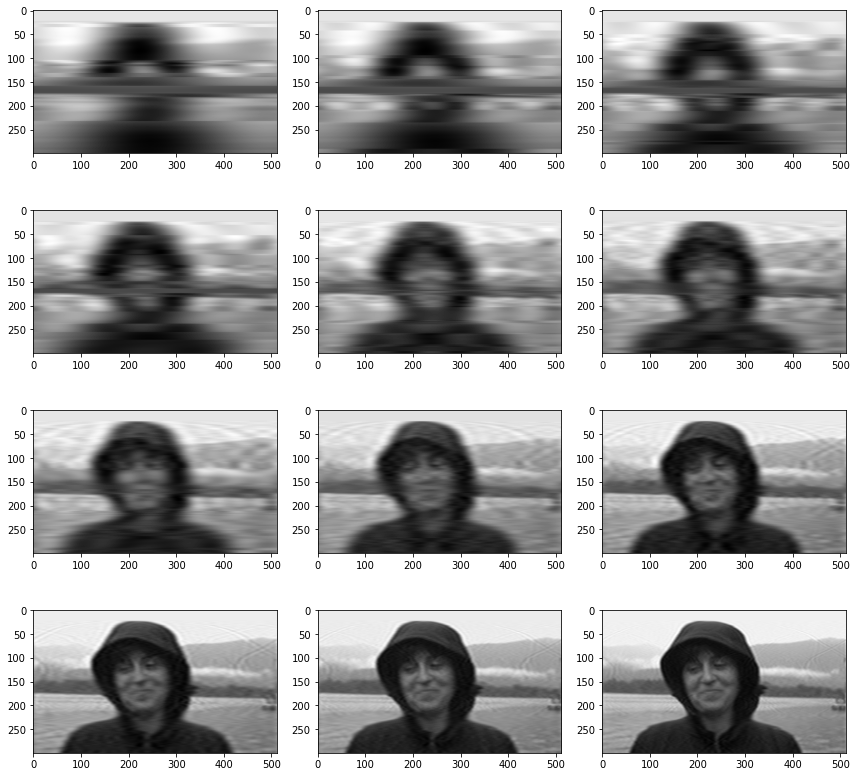

In [ ]:
import math
from matplotlib import gridspec

levels = [2.0, 1.5, 1.0, 0.8, 0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005]

db = len(levels)
mcols = 3
mrows = int(math.ceil(db / mcols))

gs = gridspec.GridSpec(mrows, mcols)
fig = plt.figure(figsize=(12, 12))

for n, v in enumerate(levels):

  ax = fig.add_subplot(gs[n])
  rec_image = fft(v, img)
  ax.imshow(rec_image, cmap='gray')

  fig.tight_layout()

In [ ]:
def show_case(_img, _threshold):
  '''
  Gets an image, rgb or grayscale
  '''

  if (_img.ndim == 2):
    img = _img
  if (_img.ndim == 3):
    img = to_gray_img(_img)

  rec = fft(_threshold, img)

  ravel_rec = rec.ravel()
  ravel_img = img.ravel()

  abs_error = np.abs(ravel_rec - ravel_img).sum()
  print('Absolute Error = ', abs_error)

  mae_error = np.abs(ravel_rec - ravel_img).mean()
  print('MAE = ', mae_error)

  dif = rec - img

  fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 4))
  ax0.scatter(img.ravel(), rec.ravel())
  ax1.imshow(rec, cmap='gray')
  ax2.imshow(dif, cmap='gray')
  plt.show()

Absolute Error =  3653.253692736261
MAE =  0.0237842037287517


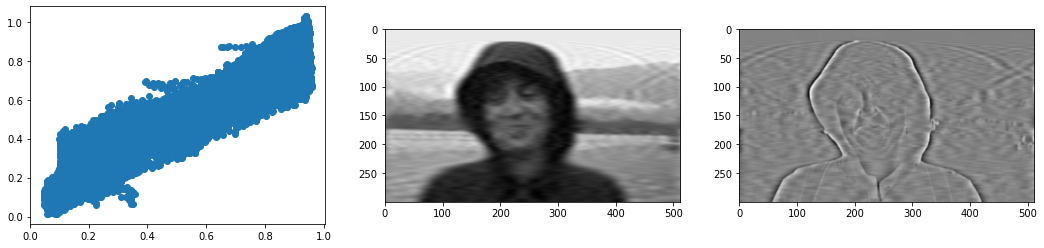

In [ ]:
show_case(img, 0.05)

Absolute Error =  2085.5193816136725
MAE =  0.013577600140714014


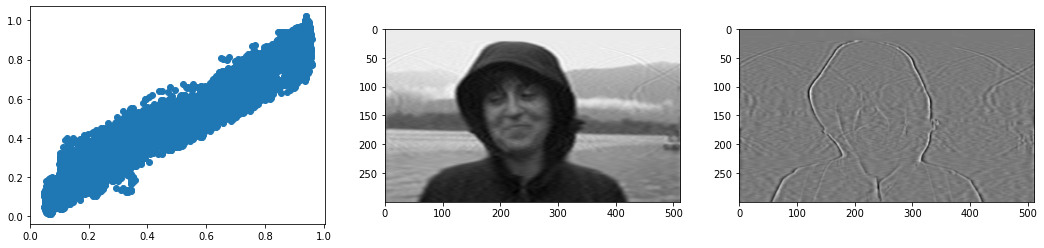

In [ ]:
show_case(img, 0.01)


Absolute Error =  825.5779798063315
MAE =  0.005374856639364138


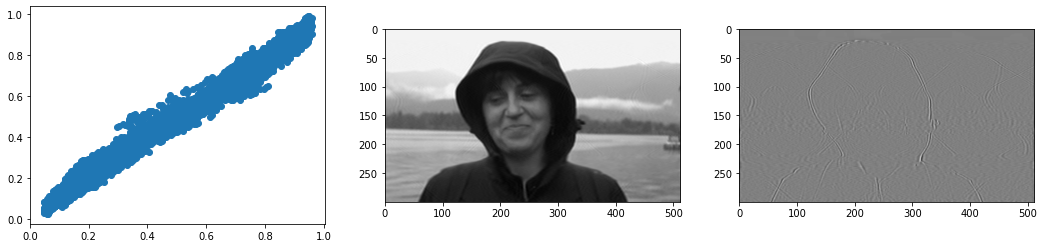

In [ ]:
show_case(img, 0.001)



```
# JoDeMiro
```
